In [ ]:
import sys
import pathlib
module_path = str(pathlib.Path().absolute()).replace('/notebooks', '')
sys.path.append(module_path)

In [ ]:
from scripts.jobs.dataset_creation import ReadRasterFile, StridedArrayGenerator, PreProcessBorderRaster, StoreCompositeDataHDF5, PreProcessPopulationRaster

raster_dem_fn = '/mnt/share/mnt/RESEARCH/SATELLITE/WORK/dem_aggr_rst.tif'
raster_pop_fn = '/mnt/share/mnt/RESEARCH/SATELLITE/WORK/pop_rst.tif'
raster_nuts_fn = '/mnt/share/mnt/RESEARCH/SATELLITE/WORK/nuts_rst.tif'

model_name = 'pop_nuts'

rasters = {
    'pop': {
        'type': 'input',
        'data': PreProcessPopulationRaster(ReadRasterFile(raster_pop_fn)),
        'bad_value_threshold': -1000
    },
    'nuts': {
        'type': 'output',
        'data': PreProcessBorderRaster(ReadRasterFile(raster_nuts_fn), bad_value=-1),
        'bad_value_threshold': -1
    }
}
strided_generator = StridedArrayGenerator(rasters, window_size = 100)
step = 0
while True:
    (train_x, train_y), (test_x, test_y) = next(strided_generator)
    if train_x.shape[0] == 0:
        break
    else:
        for i in range(2):
            selection_mask = [(x == i)[0] for x in train_y]
            StoreCompositeDataHDF5(train_x[selection_mask], train_y[selection_mask], model_name + '_train_' + str(i) + '_' + str(step))
            selection_mask = [(x == i)[0] for x in test_y]
            StoreCompositeDataHDF5(test_x[selection_mask], test_y[selection_mask], model_name + '_test_' + str(i) + '_' + str(step))
        step += 1


In [ ]:

from scripts.jobs.dataset_creation import CreateTFDatasetFromCompositeGenerator
from scripts.jobs.networks.conv_classifier import TrainConvClassifierModel

model_name = 'pop_nuts'

train_dataset = CreateTFDatasetFromCompositeGenerator(model_name + '_train', 2, batch_size = 8, window_size = 100)
test_dataset = CreateTFDatasetFromCompositeGenerator(model_name + '_test', 2, batch_size = 8, window_size = 100)

model, history = TrainConvClassifierModel(train_dataset, test_dataset, num_epochs = 10, steps_per_epoch = 1000)  # int(round(500000 / 64, 0)))
model.save('/mnt/share/mnt/RESEARCH/SATELLITE/WORK/' + model_name + '_model') 


In [6]:
from scripts.jobs.dataset_creation import CreateTFDatasetFromInMemoryGenerator, InMemoryStridedArrayGenerator, create_generator_sequence, SequenceSeparator
from scripts.jobs.networks.conv_classifier import TrainConvClassifierModel
import scripts.jobs.dataset_creation as dataset_creation
from scripts.jobs.networks.network_factory import build_network
import tensorflow as tf

raster_ww_fn = '/mnt/share/mnt/RESEARCH/SATELLITE/WORK/ww_aggr_rst.tif'
raster_dem_fn = '/mnt/share/mnt/RESEARCH/SATELLITE/WORK/dem_aggr_rst.tif'
raster_pop_fn = '/mnt/share/mnt/RESEARCH/SATELLITE/WORK/pop_rst.tif'
raster_nuts_fn = '/mnt/share/mnt/RESEARCH/SATELLITE/WORK/nuts_rst.tif'

model_name = 'pop_dem_ww_nuts_linear'
window_size = 101
train_overfit_size = 1000

rasters = {
    'pop': {
        'type': 'input',
        'data': dataset_creation.PreprocessForResnet(dataset_creation.PreProcessLogarithmPopulationRaster(dataset_creation.PreProcessPopulationRaster(dataset_creation.ReadRasterFile(raster_pop_fn)))),
        'bad_value_threshold': -1000
    },
    'dem': {
        'type': 'input',
        'data': dataset_creation.PreprocessForResnet(dataset_creation.PreprocessDEMRaster(dataset_creation.ReadRasterFile(raster_dem_fn))),
        'bad_value_threshold': -1000
    },
    'ww': {
        'type': 'input',
        'data': dataset_creation.PreprocessForResnet(dataset_creation.PreProcessWWRaster(dataset_creation.ReadRasterFile(raster_ww_fn))),
        'bad_value_threshold': -1000
    },
    'nuts': {
        'type': 'output',
        'data': dataset_creation.PreProcessBorderRaster(dataset_creation.ReadRasterFile(raster_nuts_fn), bad_value=-1),
        'bad_value_threshold': -1
    }
}

full_generator_sequence = create_generator_sequence(rasters, window_size = window_size, padding_size = 140)
sequence_separator = SequenceSeparator(rasters, window_size = window_size)
generator_sequences = sequence_separator(full_generator_sequence)
train_sizes = [int(len(generator_sequence) * 0.8) for generator_sequence in generator_sequences]
total_size = sum([len(generator_sequence)for generator_sequence in generator_sequences])
train_overfit_size = total_size

train_gen = InMemoryStridedArrayGenerator(
    rasters,
    window_size = window_size,
    generator_sequences = [generator_sequence[0:int(len(generator_sequence) * 0.8 * train_overfit_size/total_size)] for generator_sequence in generator_sequences]
)
train_dataset = CreateTFDatasetFromInMemoryGenerator(train_gen, batch_size = 64, window_size = window_size, channel_n = len(rasters) - 1)
test_gen = InMemoryStridedArrayGenerator(
    rasters,
    window_size = window_size,
    generator_sequences = [generator_sequence[int(len(generator_sequence) * 0.8):] for generator_sequence in generator_sequences]
)
test_dataset = CreateTFDatasetFromInMemoryGenerator(test_gen, batch_size = 64, window_size = window_size, channel_n = len(rasters) - 1)

# internal_model = build_network('simple_cnn', internal_dense_size = 100)
# internal_model = build_network('simple_resnet', internal_dense_size = 100, input_size = window_size, channel_n = len(rasters) - 1)
internal_model = build_network('linear')

model, history = TrainConvClassifierModel(
    train_dataset,
    test_dataset,
    num_epochs = 100,
    steps_per_epoch = 1000,
    internal_model = internal_model
)

for i in range(0,0):
    train_overfit_size = int(train_overfit_size * 1.2)
    if train_overfit_size > total_size:
        break
    train_gen = InMemoryStridedArrayGenerator(
        rasters,
        window_size = window_size,
        generator_sequences = [generator_sequence[0:int(len(generator_sequence) * 0.8 * train_overfit_size/total_size)] for generator_sequence in generator_sequences]
    )
    train_dataset = CreateTFDatasetFromInMemoryGenerator(train_gen, batch_size = 64, window_size = window_size, channel_n = len(rasters) - 1)

    print(train_overfit_size)
    model, history = TrainConvClassifierModel(
        train_dataset,
        test_dataset,
        num_epochs = 10,
        steps_per_epoch = 1000,
        internal_model = internal_model,
        complete_model = model
    )

model.save('/mnt/share/mnt/RESEARCH/SATELLITE/WORK/' + model_name + '_model')

Epoch 1/100
1000/1000 [==============================] - 6s 6ms/step - loss: 24405442.0000 - mae: 0.4930 - accuracy: 0.5070 - val_loss: 30355422.0000 - val_mae: 0.4900 - val_accuracy: 0.5100
Epoch 2/100
1000/1000 [==============================] - 11s 11ms/step - loss: 75865240.0000 - mae: 0.4840 - accuracy: 0.5160 - val_loss: 95351328.0000 - val_mae: 0.4100 - val_accuracy: 0.5900
Epoch 3/100
1000/1000 [==============================] - 8s 8ms/step - loss: 166770816.0000 - mae: 0.4590 - accuracy: 0.5410 - val_loss: 244721296.0000 - val_mae: 0.4000 - val_accuracy: 0.6000
Epoch 4/100
1000/1000 [==============================] - 7s 7ms/step - loss: 180352768.0000 - mae: 0.4310 - accuracy: 0.5690 - val_loss: 194243712.0000 - val_mae: 0.4000 - val_accuracy: 0.6000
Epoch 5/100
1000/1000 [==============================] - 7s 7ms/step - loss: 229351104.0000 - mae: 0.4370 - accuracy: 0.5630 - val_loss: 164159984.0000 - val_mae: 0.3300 - val_accuracy: 0.6700
Epoch 6/100
1000/1000 [==============

[0.0]


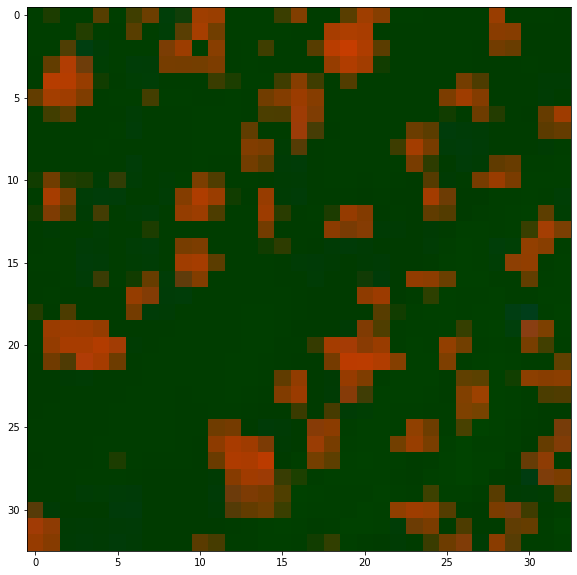

In [12]:
from matplotlib import pyplot

pyplot.figure(figsize = (10,10))
a = next(train_gen)[0]
print(next(train_gen)[1])
pyplot.imshow(a, cmap='viridis')
pyplot.show()

In [7]:
import tensorflow as tf
import numpy as np
import scripts.jobs.dataset_creation as dataset_creation
from scripts.jobs.model_prediction import PredictClassifierRaster, WriteResultRaster, FilterPredictionRaster

model_name = 'pop_dem_ww_nuts_linear'
window_size = 101

raster_ww_fn = '/mnt/share/mnt/RESEARCH/SATELLITE/WORK/ww_aggr_rst.tif'
raster_dem_fn = '/mnt/share/mnt/RESEARCH/SATELLITE/WORK/dem_aggr_rst.tif'
raster_pop_fn = '/mnt/share/mnt/RESEARCH/SATELLITE/WORK/pop_rst.tif'
raster_nuts_fn = '/mnt/share/mnt/RESEARCH/SATELLITE/WORK/nuts_rst.tif'
model = tf.keras.models.load_model('/mnt/share/mnt/RESEARCH/SATELLITE/WORK/' + model_name + '_model') 

a = dataset_creation.PreprocessForResnet(dataset_creation.PreProcessLogarithmPopulationRaster(dataset_creation.PreProcessPopulationRaster(dataset_creation.ReadRasterFile(raster_pop_fn))))
b = dataset_creation.PreprocessForResnet(dataset_creation.PreprocessDEMRaster(dataset_creation.ReadRasterFile(raster_dem_fn)))
c = dataset_creation.PreprocessForResnet(dataset_creation.PreProcessWWRaster(dataset_creation.ReadRasterFile(raster_ww_fn)))
a = np.stack([a, b, c], axis = -1).astype(np.float32)
# a = np.stack([a] * 3, axis = -1)

data = PredictClassifierRaster(a, model, stride = window_size, channel_n = 3)

out_rst_fn = '/mnt/share/mnt/RESEARCH/SATELLITE/WORK/result_' + model_name + '.tif'
WriteResultRaster(data, raster_dem_fn, out_rst_fn, channels=0)

data = FilterPredictionRaster(dataset_creation.PreProcessBorderRaster(dataset_creation.ReadRasterFile(raster_nuts_fn), bad_value=-1), data)
out_rst_fn = '/mnt/share/mnt/RESEARCH/SATELLITE/WORK/result_comparison_' + model_name + '.tif'
WriteResultRaster(data, raster_dem_fn, out_rst_fn, channels=0)


In [5]:
from sklearn.linear_model import LogisticRegression
import scripts.jobs.dataset_creation as dataset_creation

raster_ww_fn = '/mnt/share/mnt/RESEARCH/SATELLITE/WORK/ww_aggr_rst.tif'
raster_dem_fn = '/mnt/share/mnt/RESEARCH/SATELLITE/WORK/dem_aggr_rst.tif'
raster_pop_fn = '/mnt/share/mnt/RESEARCH/SATELLITE/WORK/pop_rst.tif'
raster_nuts_fn = '/mnt/share/mnt/RESEARCH/SATELLITE/WORK/nuts_rst.tif'

model_name = 'pop_dem_ww_nuts_linear'
window_size = 33
training_size = 10000

rasters = {
    'pop': {
        'type': 'input',
        'data': dataset_creation.PreprocessForResnet(dataset_creation.PreProcessLogarithmPopulationRaster(dataset_creation.PreProcessPopulationRaster(dataset_creation.ReadRasterFile(raster_pop_fn)))),
        'bad_value_threshold': -1000
    },
    'dem': {
        'type': 'input',
        'data': dataset_creation.PreprocessForResnet(dataset_creation.PreprocessDEMRaster(dataset_creation.ReadRasterFile(raster_dem_fn))),
        'bad_value_threshold': -1000
    },
    'ww': {
        'type': 'input',
        'data': dataset_creation.PreprocessForResnet(dataset_creation.PreProcessWWRaster(dataset_creation.ReadRasterFile(raster_ww_fn))),
        'bad_value_threshold': -1000
    },
    'nuts': {
        'type': 'output',
        'data': dataset_creation.PreProcessBorderRaster(dataset_creation.ReadRasterFile(raster_nuts_fn), bad_value=-1),
        'bad_value_threshold': -1
    }
}

full_generator_sequence = dataset_creation.create_generator_sequence(rasters, window_size = window_size)
sequence_separator = dataset_creation.SequenceSeparator(rasters, window_size = window_size)
generator_sequences = sequence_separator(full_generator_sequence)
generator_sequence = generator_sequences[0] + generator_sequences[1]

log_regr = LogisticRegression(warm_start=True, random_state=0, verbose = 1, solver = 'saga', max_iter = 200, n_jobs = 4)

train_dataset_generator = dataset_creation.InMemoryStridedArrayGeneratorForLogisticRegression(rasters, window_size = window_size, generator_sequence = generator_sequence, batch_size = training_size)
for i in range(5):
    X, y = next(train_dataset_generator)
    log_regr.fit(X, y)
    print(log_regr.score(X[y == 0], y[y == 0]))
    print(log_regr.score(X[y == 1], y[y == 1]))


ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
from scripts.jobs.dataset_creation import ReadRasterFile, PreProcessBorderRaster, StoreCompositeDataHDF5, PreProcessPopulationRaster, PreprocessForResnet, PreProcessLogarithmPopulationRaster, PreProcessDEMRaster
from matplotlib import pyplot

raster_nuts_fn = '/mnt/share/mnt/RESEARCH/SATELLITE/WORK/nuts_rst.tif'
raster_dem_fn = '/mnt/share/mnt/RESEARCH/SATELLITE/WORK/dem_aggr_rst.tif'
raster_pop_fn = '/mnt/share/mnt/RESEARCH/SATELLITE/WORK/pop_rst.tif'

pyplot.figure(figsize = (10,10))
a = PreProcessBorderRaster(ReadRasterFile(raster_nuts_fn), bad_value = -1)
pyplot.imshow(a, cmap='tab10')
pyplot.show()

pyplot.figure(figsize = (10,10))
pyplot.imshow(PreprocessForResnet(PreProcessLogarithmPopulationRaster(PreProcessPopulationRaster(ReadRasterFile(raster_pop_fn)))), cmap='viridis')  # viridis
pyplot.show()
pyplot.figure(figsize = (10,10))
a = PreprocessForResnet(PreProcessDEMRaster(ReadRasterFile(raster_dem_fn)))
pyplot.imshow(a, cmap='viridis')
pyplot.show()


In [ ]:
a = ReadRasterFile('/mnt/share/mnt/RESEARCH/SATELLITE/WORK/pop_rst.tif')
a[a < -10] = -10
a[(a < 3) & (a > -10)] = 0
a[a > 2] = 1
pyplot.hist(a, bins='auto') 
pyplot.show()